# Voting History

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Historical-plots" data-toc-modified-id="Historical-plots-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Historical plots</a></span><ul class="toc-item"><li><span><a href="#Minor-parties" data-toc-modified-id="Minor-parties-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Minor parties</a></span></li><li><span><a href="#Mainstream-parties" data-toc-modified-id="Mainstream-parties-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Mainstream parties</a></span></li></ul></li></ul></div>

## Python setup

In [1]:
# data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# system imports
from io import StringIO
import pathlib

# local imports
import common
from common import COLOR_COALITION, COLOR_LABOR

In [2]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')

## Data

In [3]:
data = """
Year    ALP     LP      LNP  NP      CLP  DLP  DEM     GRN     ON   Others 
1946    49.7    33.0    -    10.7    -    -    -       -       -    6.6     
1949    46.0    39.3    -    10.8    -    -    -       -       -    3.9     
1951    47.7    40.5    -    9.7     -    -    -       -       -    2.1     
1954    50.1    38.5    -    8.5     -    -    -       -       -    2.9     
1955    44.7    39.7    -    7.9     -    5.1  -       -       -    2.6     
1958    42.9    37.1    -    9.3     -    9.4  -       -       -    1.3     
1961    48.0    33.5    -    8.5     -    8.7  -       -       -    1.4     
1963    45.5    37.1    -    8.9     -    7.4  -       -       -    1.0     
1966    40.0    40.1    -    9.8     -    7.3  -       -       -    2.7     
1969    47.0    34.8    -    8.6     -    6.0  -       -       -    3.7     
1972    49.6    32.0    -    9.4     -    5.2  -       -       -    3.7     
1974    49.3    34.9    -    10.8    -    1.4  -       -       -    3.5     
1975    42.8    41.8    -    11.0    0.2  1.3  -       -       -    2.8     
1977    39.6    38.1    -    9.8     0.2  1.4  9.4     -       -    1.4     
1980    45.1    37.4    -    8.6     0.2  0.3  6.6     -       -    1.7     
1983    49.5    34.4    -    9.0     0.2  0.2  5.0     -       -    1.7     
1984    47.5    34.1    -    10.6    0.3  0.6  5.4     -       -    1.4     
1987    45.8    34.3    -    11.5    0.2  -    6.0     -       -    2.0     
1990    39.4    34.8    -    8.4     0.3  -    11.3    1.4     -    4.4     
1993    44.9    36.8    -    7.2     0.3  -    3.8     1.9     -    5.2     
1996    38.8    38.7    -    8.2     0.4  -    6.8     2.9     -    4.3     
1998    40.1    33.9    -    5.3     0.3  -    5.1     2.6     8.4  4.2     
2001    37.8    37.1    -    5.6     0.3  -    5.4     5.0     4.3  4.4     
2004    37.6    40.5    -    5.9     0.3  -    1.2     7.2     1.2  6.0     
2007    43.4    36.3    -    5.5     0.3  -    0.7     7.8     0.3  5.8     
2010    38.0    30.5    9.1  3.7     0.3  -    0.2     11.8    0.2  6.2     
2013    33.4    32.0    8.9  4.3     0.3  0.3  -       8.6     0.2  11.9    
2016    34.7    28.7    8.5  4.6     0.2  -    -       10.2    1.3  11.7    
2019    33.34   27.99   8.67 4.51    0.27 -    -       10.40   3.08 11.74      
"""
#ElectYr ALP     LP      LNP NP      CLP DLP DEM     GRN     ON  Others  Total

In [4]:
table = pd.read_csv(StringIO(data), sep='\s+', index_col=0,
                    skipinitialspace=True, na_values=['-'])

# quick check, note on column additions ...
table.tail().pipe(lambda x: x.assign(Total = x.sum(axis=1)))

,ALP,LP,LNP,NP,CLP,DLP,DEM,GRN,ON,Others,Total
Year,,,,,,,,,,,
2007,43.40,36.30,NaN,5.50,0.30,NaN,0.7,7.8,0.30,5.80,100.1
2010,38.00,30.50,9.10,3.70,0.30,NaN,0.2,11.8,0.20,6.20,100.0
2013,33.40,32.00,8.90,4.30,0.30,0.3,NaN,8.6,0.20,11.90,99.9
2016,34.70,28.70,8.50,4.60,0.20,NaN,NaN,10.2,1.30,11.70,99.9
2019,33.34,27.99,8.67,4.51,0.27,NaN,NaN,10.4,3.08,11.74,100.0


In [5]:
coalition = ['LP', 'LNP', 'NP', 'CLP']
others = ['DLP', 'DEM', 'GRN', 'ON', 'Others']

## Historical plots

### Minor parties

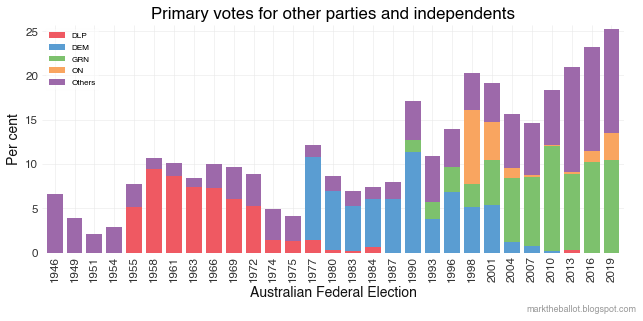

In [6]:
fig, ax = common.initiate_plot()
table[others].plot.bar(stacked=True, ax=ax, width=0.8)
common.plot_finalise(ax, title='Primary votes for other parties and independents', 
              xlabel="Australian Federal Election", ylabel='Per cent', lfooter=None)

### Mainstream parties

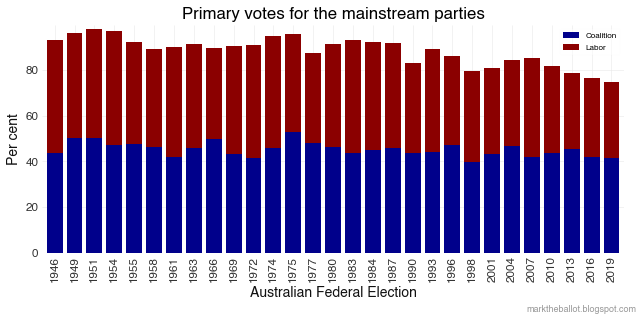

In [7]:
table['Coalition'] = table[coalition].sum(axis=1)
table = table.rename(columns={'ALP': 'Labor'})
majors = ['Coalition', 'Labor']
fig, ax = common.initiate_plot()
table[majors].plot.bar(stacked=True, ax=ax, width=0.8, 
                       color=[COLOR_COALITION, COLOR_LABOR])
common.plot_finalise(ax, title='Primary votes for the mainstream parties', 
              xlabel="Australian Federal Election", ylabel='Per cent', lfooter=None)